Notebook for investigating JONSWAP waves. <br/>
References: <br/>
DNVGL-RP-F109 On-bottom stability design of submarine pipelines, edition May 2017. <br/>
DNVGL-RP-C205 Environmental conditions and environmental loads, edition August 2017. <br/>
Soulsby, R.L.and Smallman, J.V., 1986, A direct method of calculating bottom orbital velocity under waves, Technical Report No. SR76, Hydraulics Research Wallingford. http://eprints.hrwallingford.co.uk/761/

In [159]:
%matplotlib inline

In [160]:
import numpy as np
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt

$S_{\eta\eta} = \alpha \cdot g^2 \cdot \omega^{-5} \cdot 
\exp^{-\frac{5}{4}\left(\frac{\omega}{\omega_p}\right)^{-4}} \cdot 
\gamma^{\exp\left(-0.5 \left(\frac{\omega-\omega_p}{\sigma \cdot \omega_p}  \right)^2   \right)}$ 
&nbsp; &nbsp; &nbsp; JONSWAP spectrum «S_etaeta»

$\alpha = \frac{5}{16} \cdot \frac{H_s^2 \cdot \omega_p^4}{g^2} \cdot 
\left(1 - 0.287 \cdot \ln{\gamma}  \right)$ 
&nbsp; &nbsp; &nbsp; Phillip's constant «phillips»

$\sigma = \begin{cases}
               0.07 \quad if \, \omega < \omega_p\\
               0.09 \quad else\\
            \end{cases} $
&nbsp; &nbsp; &nbsp; Spectral width parameter «sigma»

$\gamma = \begin{cases}
               5.0 \hspace{9em} \phi \leq 3.6\\
               \exp \left(5.75-1.15 \phi   \right) \qquad 3.6 < \phi < 5.0\\
               1.0 \hspace{9em} \phi \geq 5.0\\
            \end{cases} $
&nbsp; &nbsp; &nbsp; Peak-enhancement factor «gamma»

$\phi = \frac{T_p}{\sqrt{H_s}}$ &nbsp; &nbsp; &nbsp;  «phi»

Ref: DNVGL-RP-F109, sec. 3.4.3, p. 16, eqns. 3.4, 3.5, 3.6, 3.7

In [161]:
def JONSWAP(omega, H_s, T_p, grav_acc=9.81, gamma=None):
    omega_p = 2*np.pi/T_p
    sigma = np.full(omega.shape, 0.09)
    sigma[omega<=omega_p] = 0.07
    phi = T_p / np.sqrt(H_s)
    if not gamma:
        if phi<=3.6:
            gamma = 5
        elif 3.6<phi<5:
            gamma = np.exp(5.75-1.15*phi)
        else:
            gamma = 1
    phillips = ( 5/16 * H_s**2 * 
                omega_p**4 / grav_acc**2 * 
                (1-0.287*np.log(gamma)) )
    S_etaeta = ( phillips * grav_acc**2 * omega**-5 * 
                np.exp(-5/4 * (omega/omega_p)**-4 ) *
                gamma**np.exp(-0.5*((omega-omega_p)/(sigma*omega_p))**2 ) )
    return S_etaeta, gamma

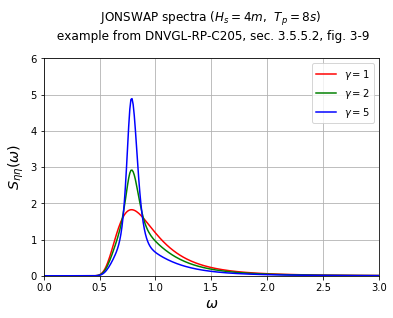

In [162]:
omega = np.linspace(0.01, 3.0, 300)
S_etaeta1, gamma = JONSWAP(omega, H_s=4, T_p=8, gamma=1)
S_etaeta2, gamma = JONSWAP(omega, H_s=4, T_p=8, gamma=2)
S_etaeta3, gamma = JONSWAP(omega, H_s=4, T_p=8, gamma=5)
plt.title("JONSWAP spectra ($H_s=4m$,  $T_p=8s$) \n example from DNVGL-RP-C205, sec. 3.5.5.2, fig. 3-9\n")
plt.plot(omega, S_etaeta1, '-r', label='$\gamma=1$')
plt.plot(omega, S_etaeta2, '-g', label='$\gamma=2$')
plt.plot(omega, S_etaeta3, '-b', label='$\gamma=5$')
plt.xlim([0,3])
plt.ylim([0,6])
plt.xlabel("$\omega$", size="x-large")
plt.ylabel("$S_{\eta\eta}(\omega)$", size="x-large")
plt.grid(True)
plt.legend(loc='best')

$T = \left[ \frac{g}{2\pi\lambda}  \cdot \tanh \left( \frac{2\pi d}{\lambda} \right) \right]^{-\frac{1}{2}}$
&nbsp; &nbsp; &nbsp; $\lambda$ wave length «wavelen», &nbsp; &nbsp; &nbsp; T wave period

$k = \frac{2 \pi}{\lambda}$ &nbsp; &nbsp;wave number,
&nbsp; &nbsp; &nbsp; 
$\omega = \frac{2 \pi}{T}$ &nbsp; &nbsp; angular frequency «omega»

Ref: DNVGL-RP-C205, sec. 3.2.2.3, p. 46

In [163]:
def find_wavelen_func(_lambda, T, depth, grav_acc=9.81):
    return T**2 - 2*np.pi*_lambda/grav_acc / np.tanh(2*np.pi*depth/_lambda)

In [164]:
def calc_wave_length(T, depth, grav_acc=9.81):
    if isinstance(T, np.ndarray):
        wavelen = np.zeros_like(T)
        for ii, _T in enumerate(T):
            try:
                wavelen[ii] = scipy.optimize.bisect(find_wavelen_func,  
                                        0.1, 1000, args=(_T, depth))
            except ValueError as err:
                wavelen[ii] = np.NaN
    else:
        wavelen = scipy.optimize.bisect(find_wavelen_func, 0.1, 1000, 
                                    args=(T, depth))
    return wavelen

In [165]:
T=10; depth=2000
wavelen = calc_wave_length(T, depth)
print(f"wave length={wavelen:.3f}m  (T={T}s, depth={depth}m)")
T=10; depth=1
wavelen = calc_wave_length(T, depth)
print(f"wave length={wavelen:.3f}m  (T={T}s, depth={depth}m)")
T=15; depth=90
wavelen = calc_wave_length(T, depth)
print(f"wave length={wavelen:.3f}m  (T={T}s, depth={depth}m)")

wave length=156.131m  (T=10s, depth=2000m)
wave length=31.111m  (T=10s, depth=1m)
wave length=329.340m  (T=15s, depth=90m)


$S_{UU}(\omega) = G^2(\omega) \cdot S_{\eta\eta}(\omega)$

$G(\omega) = \frac{\omega}{\sinh(k \cdot d)}$

Ref: DNVGL-RP-F109, sec. 3.4.3, p. 17, eqns. 3.8, 3.9

In [166]:
def JONSWAP_depth_transform(omega, S_etaeta, depth, D=0, e=0, grav_acc=9.81): 
    T = 2*np.pi/omega 
    wavelen = calc_wave_length(T, depth)
    k = 2*np.pi/wavelen
    G = omega*np.cosh(k*(D+e))/np.sinh(k*depth)
    S_uu = G**2 * S_etaeta
    return S_uu, G

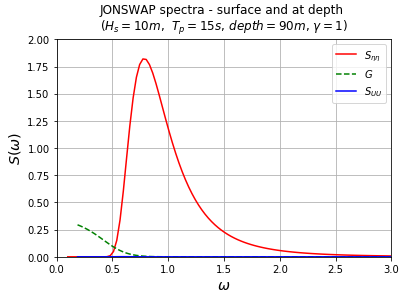

In [167]:
omega = np.linspace(0.01, 3.0, 300)
T_p=15; depth=90; H_s=10
omega = np.linspace(0.1, 3.0, 100)
S_etaeta, gamma = JONSWAP(omega, H_s=4, T_p=8, gamma=1)
S_uu, G = JONSWAP_depth_transform(omega, S_etaeta, D=0, depth=depth)
plt.title(f"JONSWAP spectra - surface and at depth \n($H_s={H_s}m$,  $T_p={T_p}s$, $depth={depth}m$, $\gamma={gamma}$)")
plt.plot(omega, S_etaeta, '-r', label='$S_{\eta\eta}$')
plt.plot(omega, G, '--g', label='$G$')
plt.plot(omega, S_uu, '-b', label='$S_{UU}$')
plt.xlim([0,3])
plt.ylim([0,2])
plt.xlabel("$\omega$", size="x-large")
plt.ylabel("$S(\omega)$", size="x-large")
plt.grid(True)
plt.legend(loc='best')

In [168]:
T_p=15; depth=90; H_s=10
omega = np.linspace(0.1, 3.0, 100)
S_etaeta, gamma = JONSWAP(omega, H_s=H_s, T_p=T_p, gamma=1)
M_0 = 1/16 * H_s**2   # DNVGL-RP-C205, sec. 3.5.5.3, p. 66
U_s = 2 * np.sqrt(M_0)
print(f"approx. M_0 = {M_0}, U_s={U_s}")
M_0 = scipy.integrate.trapz(S_etaeta, omega)
print(f"M_0 = {M_0}")
M_2 = 1/16 * H_s**2 * (2*np.pi/T_p)**2 * (11+gamma)/(5+gamma)  # DNVGL-RP-C205, sec. 3.5.5.3, p. 66
print(f"approx. M_2 = {M_2}")
M_2 = scipy.integrate.trapz(S_etaeta*omega**2, omega)
print(f"M_2 = {M_2}")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")
S_uu, G = JONSWAP_depth_transform(omega, S_etaeta, D=0, depth=depth)
S_uu = np.nan_to_num(S_uu)
#print(S_uu)
M_0 = scipy.integrate.trapz(S_uu, omega)
print(f"M_0 = {M_0}, depth={depth}")
M_2 = scipy.integrate.trapz(S_uu*omega**2, omega)
print(f"M_2 = {M_2}, depth={depth}")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")

approx. M_0 = 6.25, U_s=5.0
M_0 = 6.247031239490564
approx. M_2 = 2.193245422464302
M_2 = 2.119695233924831
U_s = 4.998812354746101
T_u = 10.786486283961281
M_0 = 0.09946216862130082, depth=90
M_2 = 0.01625091062949805, depth=90
U_s = 0.6307524668879253
T_u = 15.54425740865491


In [169]:
# example DNV-RP-F105 course p. 67
T_p=15; depth=90; H_s=10
T_n = np.sqrt(depth/9.81)
print(f"T_n = {T_n}")
T_n_T_p = T_n/T_p
print(f"T_n/T_p = {T_n_T_p}")
U_s = 0.2*H_s/T_n
print(f"U_s = {U_s}")

T_n = 3.0289126640769135
T_n/T_p = 0.2019275109384609
U_s = 0.660302960768767


In [170]:
# 1986 Soulsby and Smallman  p. 17
T_z=10; depth=50; H_s=5
T_p = 1.281 *T_z  # eq. 19, p. 13  (see also Table 1 in appendix)
omega = np.linspace(0.1, 3.0, 100)
S_etaeta, gamma = JONSWAP(omega, H_s=H_s, T_p=T_p, gamma=1)
M_0 = 1/16 * H_s**2   # DNVGL-RP-C205, sec. 3.5.5.3, p. 66
U_s = 2 * np.sqrt(M_0)
print(f"approx. M_0 = {M_0}, U_s={U_s}")
M_0 = scipy.integrate.trapz(S_etaeta, omega)
print(f"M_0 = {M_0}")
M_2 = 1/16 * H_s**2 * (2*np.pi/T_p)**2 * (11+gamma)/(5+gamma)  # DNVGL-RP-C205, sec. 3.5.5.3, p. 66
print(f"approx. M_2 = {M_2}")
M_2 = scipy.integrate.trapz(S_etaeta*omega**2, omega)
print(f"M_2 = {M_2}")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")
S_uu, G = JONSWAP_depth_transform(omega, S_etaeta, D=0, depth=depth)
S_uu = np.nan_to_num(S_uu)
#print(S_uu)
M_0 = scipy.integrate.trapz(S_uu, omega)
print(f"M_0 = {M_0}, depth={depth}")
M_2 = scipy.integrate.trapz(S_uu*omega**2, omega)
print(f"M_2 = {M_2}, depth={depth}")
T_n = np.sqrt(depth/9.81)
print(f"T_n = {T_n}, depth={depth}")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")

approx. M_0 = 1.5625, U_s=2.5
M_0 = 1.5611047766495092
approx. M_2 = 0.7518158872369117
M_2 = 0.7198081834465321
U_s = 2.4988835720373284
T_u = 9.253105306233785
M_0 = 0.06997540546193502, depth=50
M_2 = 0.017071438432567032, depth=50
T_n = 2.2576182049286544, depth=50
U_s = 0.5290572954300319
T_u = 12.720890728873341


In [184]:
def calc_Us_Tu_at_depth(depth, H_s, T_p, gamma=1, grav_acc=9.81):
    omega = np.linspace(0.1, 5.0, 600)
    S_etaeta, gamma = JONSWAP(omega, H_s=H_s, T_p=T_p, gamma=gamma)
    S_uu, G = JONSWAP_depth_transform(omega, S_etaeta, D=0, depth=depth)
    S_uu = np.nan_to_num(S_uu)
    M_0 = scipy.integrate.trapz(S_uu, omega)
    M_2 = scipy.integrate.trapz(S_uu*omega**2, omega)     
    U_s = 2 * np.sqrt(M_0)
    T_u = 2 * np.pi * np.sqrt(M_0/M_2)
    T_n = np.sqrt(depth/grav_acc)
    return U_s, T_u, T_n

In [172]:
# Soulsby & Smallman (1986), p. 17
H_s = 5
T_z = 8
T_p = 1.281*T_z
gamma=1
depth=10
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
Tn_Tz = T_n/T_z
print(f"U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, T_n/T_z={Tn_Tz:.3f}, depth={depth}")
U_m = np.sqrt(2) * U_s
print(f"U_m={U_m}")
depth=50
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
Tn_Tz = T_n/T_z
print(f"U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, T_n/T_z={Tn_Tz:.3f}, depth={depth}")
# results not consistent (M_2 not correct??, see below)

U_s=1.951, T_u=8.772, T_n=1.010, T_n/T_z=0.126, depth=10
U_m=2.7596485401595983
U_s=0.355, T_u=10.927, T_n=2.258, T_n/T_z=0.282, depth=50


In [173]:
# 2016 Thesis SPECIFIC SOFTWARE TOOL DEVELOPMENT FOR RIGID PIPELINE DESIGN, Nuno Filipe Salsa da Silva Ferreira
# https://fenix.tecnico.ulisboa.pt/downloadFile/1689244997255722/dissertacao.pdf
# sec. 5.2.4, p. 83;  M0=0.5184 m /Hz; M2=0.0043 m /Hz
gamma = 1   # page 72
H_s = 2.88
T_p = 15.5
#U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
#print(f"U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, T_n/T_z={Tn_Tz:.3f}, depth={depth}")
depth = 0
omega = np.linspace(0.01, 10.0, 1000)
S_etaeta, gamma = JONSWAP(omega, H_s=H_s, T_p=T_p, gamma=gamma)
M_0 = scipy.integrate.trapz(S_etaeta, omega)
print(f"M_0 = {M_0}, depth={depth} (expected 0.5184) ")
M_2 = scipy.integrate.trapz(S_etaeta*omega**2, omega)
print(f"M_2 = {M_2}, depth={depth} (expected 0.0043)")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")
depth = 937 # minimum water depth, page 69
S_uu, G = JONSWAP_depth_transform(omega, S_etaeta, D=0, depth=depth)
S_uu = np.nan_to_num(S_uu)
#print(S_uu)
M_0 = scipy.integrate.trapz(S_uu, omega)
print(f"M_0 = {M_0}, depth={depth}")
M_2 = scipy.integrate.trapz(S_uu*omega**2, omega)
print(f"M_2 = {M_2}, depth={depth}")
U_s = 2 * np.sqrt(M_0)
print(f"U_s = {U_s}")
T_u = 2 * np.pi * np.sqrt(M_0/M_2)
print(f"T_u = {T_u}")

M_0 = 0.5183982502835391, depth=0 (expected 0.5184) 
M_2 = 0.1684573773307614, depth=0 (expected 0.0043)
U_s = 1.4399975698361982
T_u = 11.0221575464895
M_0 = 1.037236226994421e-09, depth=937
M_2 = 7.63357886030026e-11, depth=937
U_s = 6.441230401078418e-05
T_u = 23.160856109873702


/home/develop/local/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in sinh
  """


In [185]:
#GE p 35 - these results are good (slight differences in T_u)!
depth=260
H_s = 11  # 1 year
T_p = 14.6
gamma = 3.3
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
print(f"1-year U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, depth={depth}")
H_s = 13.691  # 10 year
T_p = 15.565
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
print(f"10-year U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, depth={depth}")
H_s = 16.3  # 100 year
T_p = 16.5
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
print(f"100-year U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, depth={depth}")
H_s = 18.844  # 1000 year
T_p = 17.412
U_s, T_u, T_n = calc_Us_Tu_at_depth(depth=depth, H_s=H_s, T_p=T_p, gamma=gamma)
print(f"1000-year U_s={U_s:.3f}, T_u={T_u:.3f}, T_n={T_n:.3f}, depth={depth}")

1-year U_s=0.059, T_u=17.689, T_n=5.148, depth=260
10-year U_s=0.103, T_u=18.342, T_n=5.148, depth=260
100-year U_s=0.163, T_u=18.979, T_n=5.148, depth=260
1000-year U_s=0.239, T_u=19.597, T_n=5.148, depth=260
